In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_data = pd.read_csv('../preprocessed_all_countries_combined_comments.csv')

In [3]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['body'].apply(lambda x:len(str(x).split())) 

In [4]:
print('Info about training data:')
print(train_data['label'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
positive    5961
negative    3260
neutral     1947
Name: label, dtype: int64
Total comments:  11168


In [5]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :819


In [6]:
# consider 11k comments
num_words = 5000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['body'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[1, 1, 1, 28]]


In [7]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['body'],\
                                                      train_data['label'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [8]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-8-52717cdf9361>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-8-52717cdf9361>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [9]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 819.
# here we are taking maxlen=256 and applying padding.
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [10]:
x_train.shape

(10051, 256)

In [11]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['negative', 'neutral', 'positive']

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [13]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

9704     negative
836      negative
2701     positive
8805     positive
8506     negative
6502     positive
9204      neutral
10006     neutral
6053      neutral
3245     positive
Name: label, dtype: object
Text to number
[0 0 2 2 0 2 1 1 1 2]
Number to category
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [14]:

# Creating Convolutional Neural Network Model

# looking for top 30k comments
max_features = 5000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))     

# second is conv. layer.
# 1-dimensional (not image)
# kernel_size = 3, looking for 3 words at a time (total of 40).
model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005))) 

# adding maxpooling after convolution layer.
# feature map is reduced by half after max pooling.
model.add(tf.keras.layers.GlobalMaxPooling1D())

# final layer, fully connected dense layer.
# 3 neurons for the output: possitive, negative and neutral.
# regularizers prevents overfitting.
model.add(tf.keras.layers.Dense(3, activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                    
model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy",  AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 64)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 254, 128)          24704     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 345,091
Trainable params: 345,091
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Training model
epochs = 15
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(100).batch(32),
                    epochs= epochs ,
                    validation_data=test_ds.batch(32),
                    verbose=1)

Epoch 1/15
315/315 [==============================] - 7s 18ms/step - loss: 0.9941 - categorical_accuracy: 0.5813 - auc: 0.7571 - val_loss: 0.5210 - val_categorical_accuracy: 0.8469 - val_auc: 0.9525
Epoch 2/15
315/315 [==============================] - 5s 15ms/step - loss: 0.4688 - categorical_accuracy: 0.8570 - auc: 0.9625 - val_loss: 0.4953 - val_categorical_accuracy: 0.8559 - val_auc: 0.9594
Epoch 3/15
315/315 [==============================] - 5s 16ms/step - loss: 0.3743 - categorical_accuracy: 0.9063 - auc: 0.9817 - val_loss: 0.4313 - val_categorical_accuracy: 0.8908 - val_auc: 0.9740
Epoch 4/15
315/315 [==============================] - 5s 15ms/step - loss: 0.3258 - categorical_accuracy: 0.9325 - auc: 0.9901 - val_loss: 0.4236 - val_categorical_accuracy: 0.8935 - val_auc: 0.9777
Epoch 5/15
315/315 [==============================] - 5s 16ms/step - loss: 0.2976 - categorical_accuracy: 0.9526 - auc: 0.9944 - val_loss: 0.4505 - val_categorical_accuracy: 0.8890 - val_auc: 0.9747
Epoch

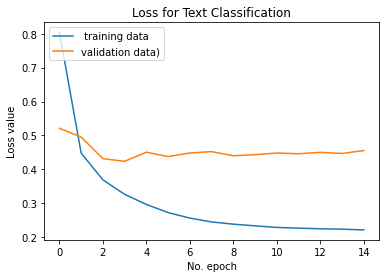

In [16]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [17]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_auc'])


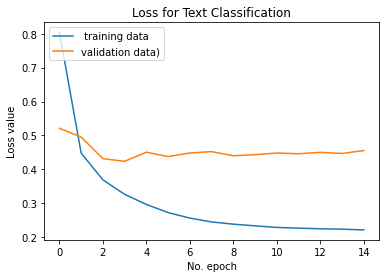

In [18]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [19]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=3263)

<ipython-input-19-57839d92eddd>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples


array([2, 2, 2, ..., 1, 0, 2], dtype=int64)

In [21]:
y_test.shape
y_test

9158     positive
1751     positive
11060    positive
9756     negative
9971     positive
           ...   
8450     positive
8484     positive
2431      neutral
5844     negative
7400     positive
Name: label, Length: 1117, dtype: object

In [22]:
y_pred = np.where((y_pred == 0),'negative',y_pred)
y_pred = np.where((y_pred == '1'),'neutral',y_pred)
y_pred = np.where((y_pred == '2'),'positive',y_pred)

In [23]:
labels = ['positive', 'negative','neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    positive       0.91      0.92      0.91       600
    negative       0.87      0.82      0.85       320
     neutral       0.87      0.95      0.91       197

    accuracy                           0.89      1117
   macro avg       0.89      0.89      0.89      1117
weighted avg       0.89      0.89      0.89      1117

